In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import torch
import numpy as np
import pandas as pd

from tqdm import tqdm

import copy
import matplotlib.pyplot as plt

from EvolvedNNPopulation import NSGSIIEvolvedNNPopulation
from EvolvedNN import EvolvedNN

from BatchLayers.StatLayers import Mean, Variance

from CombineLayers.ElementWiseLayers import Add, Multiply

from CompoundLayers.SequentialLayer import Sequential
from CompoundLayers.SplitLayer import Split

from MutableLayers.MutableSplitLayers import MutableAddSplit, MutableMulSplit, MutableMaxSplit, MutablePowSplit
from MutableLayers.MutableResizeLayers import MutableResizeFive, MutableResizeFifth

from OpLayers.AffineLayers import Linear, AddBias, LinearResize
from OpLayers.ScalarFuncLayers import Log, Exp, Identity, Abs, Sin, Reciprocal
from OpLayers.VectorFuncLayers import Pow, Scale

In [2]:
op_layers = [ Linear, AddBias, Exp, Sin, Pow ]
split_layers = [ MutableAddSplit, MutableMulSplit, MutableMaxSplit, MutablePowSplit ]
batch_layers = [ Mean, Variance ]
resize_layers = [ MutableResizeFive ]

layers = split_layers + op_layers + resize_layers + batch_layers

In [3]:
n = 300

m = 32

dim = 1
depth = 6

steps = 3
k = 3

In [4]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

population = NSGSIIEvolvedNNPopulation(dim, dim, n, device=device)

population.initialize_randomly(layers, depth, lr=0.01)
population.gen_children(k, layers, p=[0.4, 0.2, 0.4])

f = lambda x : torch.nn.functional.leaky_relu(x, negative_slope=0.1)

x_train = torch.tensor(np.linspace(start=-20, stop=20, num=200).reshape((200, 1)), dtype=torch.float32, device=device)
y_train = f(x_train)

x_test = torch.tensor(np.random.uniform(-20, 20, size=(500, 1)), dtype=torch.float32, device=device)
y_test = f(x_test)

print("Train data")
plt.plot(x_train.clone().detach().cpu().numpy(), y_train.clone().detach().cpu().numpy(), 'o')
plt.show()

print("Test data")
plt.plot(x_test.clone().detach().cpu().numpy(), y_test.clone().detach().cpu().numpy(), 'o')
plt.show()

batch_size = m

population.train_pool_dataset(x_train, y_train, epochs=50, batch_size=batch_size)
population.evaluate_pool_dataset(x_test, y_test)

population.step(percentile=0.9)

for step in range(steps):
    print(f"Step {step}")
    
    best_indices = np.arange(8)

    print(f"Best stats {population.stats[best_indices]}")
    print(f"Best NNs {[population.pool[i].cpu() for i in best_indices]}")

    print("Best NNs Predictions")

    for i in best_indices:
        best_nn = population.pool[i].to(device)

        plt.plot(x_test.clone().detach().cpu().numpy(), y_test.clone().detach().cpu().numpy(), 'o')
        plt.plot(x_test.clone().detach().cpu().numpy(), best_nn(x_test).clone().detach().cpu().numpy(), 'x')
        plt.show()

    population.gen_children(k, layers, True, p=[0.4, 0.2, 0.4])

    population.train_children_dataset(x_train, y_train, epochs=50, batch_size=batch_size)
    population.evaluate_children_dataset(x_test, y_test)

    population.step(percentile=0.9)

Initializing Randomly: 100%|██████████| 300/300 [00:02<00:00, 117.69it/s]


KeyboardInterrupt: 

Best stats tensor([[2.3499e-03, 4.9000e+01],
        [6.4430e-03, 2.5000e+01],
        [2.6429e-02, 1.0000e+01],
        [6.3805e-02, 9.0000e+00],
        [1.0924e-01, 7.0000e+00],
        [1.1589e+00, 6.0000e+00],
        [6.7099e+00, 5.0000e+00],
        [2.6517e+01, 4.0000e+00]])
Best NNs [EvolvedNN(
  dim=1
  (first): LinearResize(in_dim=1, out_dim=1, A=[[-0.15063868]])
  (latent): MutableSequential(
    dim=1
    (layers): ModuleList(
      (0): MutableMaxSplit(
        dim=1
        (left): MutableSequential(
          dim=1
          (layers): ModuleList(
            (0): Pow(dim=1, exp=[0.992387])
            (1): MutableResizeFive(
              dim=1
              (first): LinearResize(in_dim=1, out_dim=5, A=[[-2.5597963  2.2286758 -2.7452302 -2.4034934 -2.1634598]])
              (latent): MutableSequential(
                dim=5
                (layers): ModuleList(
                  (0): Identity(dim=5)
                )
              )
              (last): LinearResize(


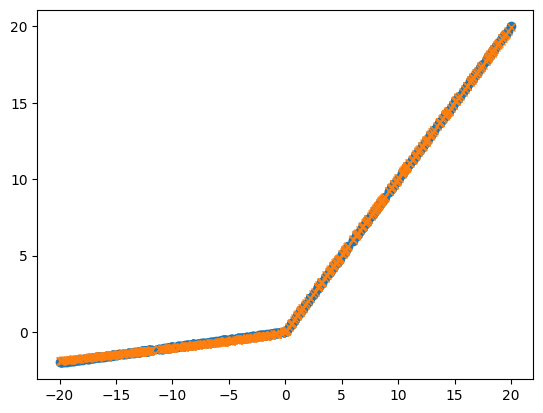

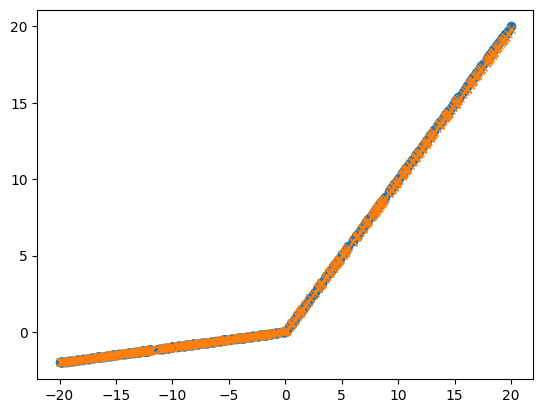

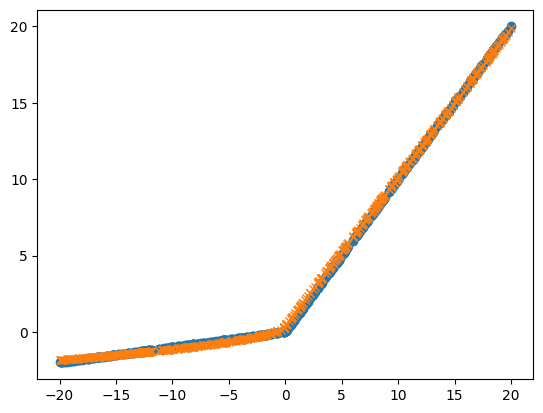

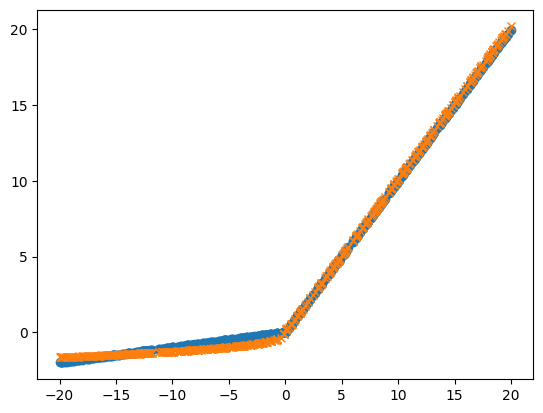

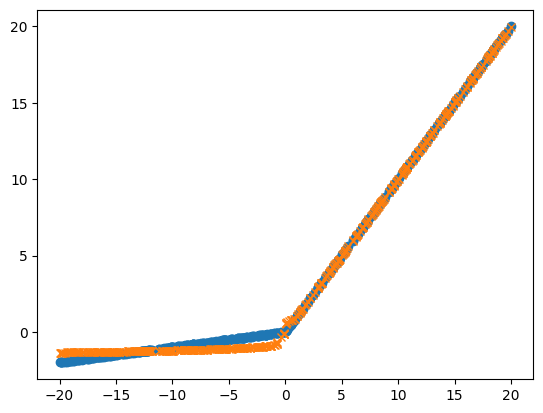

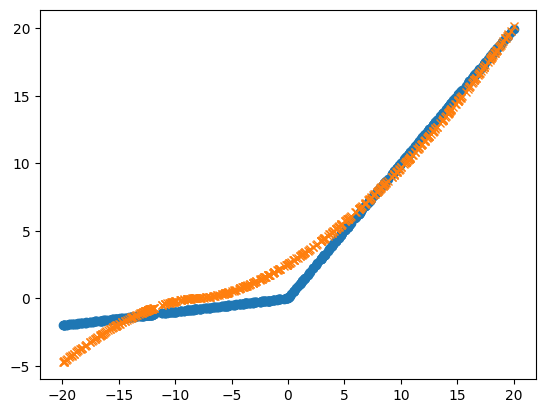

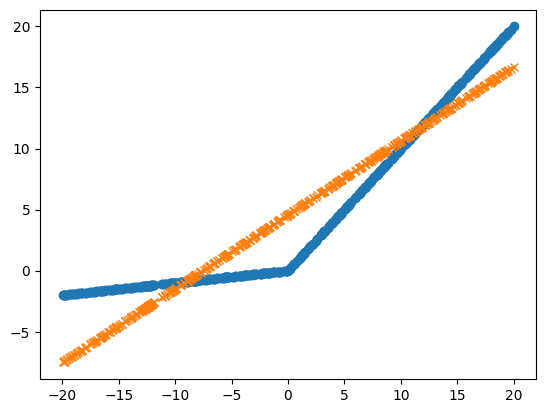

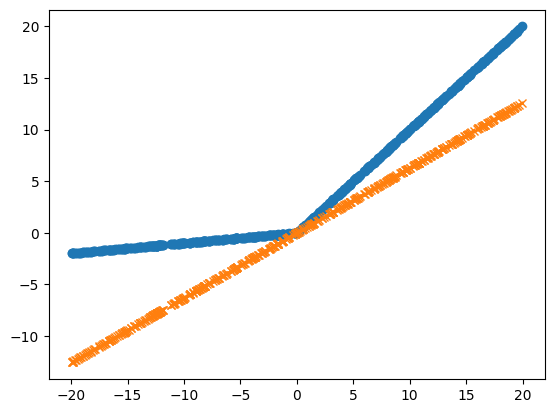

In [ ]:
best_indices = np.arange(8)

print(f"Best stats {population.stats[best_indices]}")
print(f"Best NNs {[population.pool[i].cpu() for i in best_indices]}")

print("Best NNs Predictions")

for i in best_indices:
    best_nn = population.pool[i].to(device)

    plt.plot(x_test.clone().detach().cpu().numpy(), y_test.clone().detach().cpu().numpy(), 'o')
    plt.plot(x_test.clone().detach().cpu().numpy(), best_nn(x_test).clone().detach().cpu().numpy(), 'x')
    plt.show()

In [5]:
data = pd.read_csv("data/StudentPerformance/data.csv")

predictors = data.drop(columns=["StudentID", "GPA", "GradeClass"], axis=1)
targets = data["GPA"]

train_ratio = 0.8
split = torch.randperm(len(predictors))

train_split = split[:int(train_ratio * len(data))]
test_split = split[int(train_ratio * len(data)):]

device = torch.device("cuda")

x_train = torch.tensor(predictors.values[train_split], dtype=torch.float32).to(device)
y_train = torch.tensor(targets.values[train_split], dtype=torch.float32).view(-1, 1).to(device)

x_test = torch.tensor(predictors.values[test_split], dtype=torch.float32).to(device)
y_test = torch.tensor(targets.values[test_split], dtype=torch.float32).view(-1, 1).to(device)

In [6]:
n = 300
k = 3

depth = 6
dim = len(predictors.columns)

batch_size = 32
fair_epochs = 500
steps = 3

In [7]:
op_layers = [ Linear, AddBias, Exp, Sin, Pow ]
split_layers = [ MutableAddSplit, MutableMulSplit, MutableMaxSplit, MutablePowSplit ]
batch_layers = [ Mean, Variance ]
resize_layers = [ MutableResizeFive, MutableResizeFifth ]

layers = split_layers + op_layers + resize_layers

population = NSGSIIEvolvedNNPopulation(dim, 1, n, device=device)

population.initialize_randomly(layers, depth, lr=0.01)

population.train_pool_dataset(x_train, y_train, epochs=50, batch_size=batch_size)
population.evaluate_pool_dataset(x_test, y_test)

for step in range(steps):
    population.gen_children(k, layers, p=[0.4, 0.2, 0.4])

    population.train_children_dataset(x_train, y_train, epochs=50, batch_size=batch_size)
    population.evaluate_children_dataset(x_test, y_test)

    population.step()

    print(f"Step {step}")
    
    best_indices = np.arange(5)

    print(f"Best stats {population.stats[best_indices]}")
    print(f"Best NN {[population.pool[i].cpu() for i in best_indices]}")

Initializing Randomly:   0%|          | 0/300 [00:00<?, ?it/s]

Initializing Randomly: 100%|██████████| 300/300 [00:01<00:00, 282.21it/s]


KeyboardInterrupt: 

In [ ]:
train_data = pd.read_csv("data/ConcreteStrength/train.csv")
val_data = pd.read_csv("data/ConcreteStrength/test.csv")

train_predictors = train_data.drop(["id", "Strength"], axis=1)
val_predictors = val_data.drop(["id"], axis=1)

train_targets = train_data["Strength"]

train_ratio = 0.8
split = torch.randperm(len(train_predictors))

train_split = split[:int(train_ratio * len(train_predictors))]
test_split = split[int(train_ratio * len(train_predictors)):]

device = torch.device("cuda")

x_train = torch.tensor(train_predictors.values[train_split], dtype=torch.float32).to(device)
y_train = torch.tensor(train_targets.values[train_split], dtype=torch.float32).view(-1, 1).to(device)

x_test = torch.tensor(train_predictors.values[test_split], dtype=torch.float32).to(device)
y_test = torch.tensor(train_targets.values[test_split], dtype=torch.float32).view(-1, 1).to(device)

In [ ]:
n = 300
k = 3

depth = 10
dim = len(train_predictors.columns)

batch_size = 32
fair_epochs = 500

In [ ]:
op_layers = [ Linear, AddBias, Exp, Sin, Pow ]
split_layers = [ MutableAddSplit, MutableMulSplit, MutableMaxSplit, MutablePowSplit ]
batch_layers = [ Mean, Variance ]
resize_layers = [ MutableResizeFive, MutableResizeFifth ]

layers = split_layers + op_layers + resize_layers

population = NSGSIIEvolvedNNPopulation(dim, 1, n, device=device)

population.initialize_randomly(layers, depth, lr=0.01, loss_fn=lambda x, y : torch.sqrt(torch.nn.functional.mse_loss(x, y)))
population.gen_children(k, layers, p=[0.4, 0.2, 0.4])

population.train_pool_dataset(x_train, y_train, epochs=50, batch_size=batch_size)
population.evaluate_pool_dataset(x_test, y_test)

for step in range(steps):
    print(f"Step {step}")
    
    best_indices = np.arange(5)

    print(f"Best stats {population.stats[best_indices]}")
    print(f"Best NN {[population.pool[i].cpu() for i in best_indices]}")

    population.train_children_dataset(x_train, y_train, epochs=50, batch_size=batch_size)
    population.evaluate_children_dataset(x_test, y_test)

    population.step()
    population.gen_children(k, layers, True, p=[0.4, 0.2, 0.4])

Initializing Randomly:   0%|          | 0/300 [00:00<?, ?it/s]

Evaluating Pool: 100%|██████████| 300/300 [00:00<00:00, 1180.25it/s]


NameError: name 'steps' is not defined

In [ ]:
for step in range(steps):
    print(f"Step {step}")
    
    best_indices = np.arange(5)

    print(f"Best stats {population.stats[best_indices]}")
    print(f"Best NN {[population.pool[i].cpu() for i in best_indices]}")

    population.train_children_dataset(x_train, y_train, epochs=50, batch_size=batch_size)
    population.evaluate_children_dataset(x_train, y_train)

    population.step()
    population.gen_children(k, layers, True, p=[0.4, 0.2, 0.4])

Step 0
Best stats tensor([[      nan,  120.0000],
        [  15.5453,  145.0000],
        [      nan,  128.0000],
        [      nan, 1360.0000],
        [      nan, 2744.0000]])
Best NN [EvolvedNN(
  dim=8
  (layers): ModuleList(
    (0): MutablePowSplit(
      dim=8
      (left): MutableSequential(
        dim=8
        (layers): ModuleList(
          (0): Pow(dim=8, exp=[nan nan nan nan nan nan nan nan])
          (1): MutableResizeFifth(
            dim=8
            (first): LinearResize(
              in_dim=8, out_dim=1, A=[[nan]
               [nan]
               [nan]
               [nan]
               [nan]
               [nan]
               [nan]
               [nan]]
            )
            (latent): MutableSequential(
              dim=1
              (layers): ModuleList(
                (0): Identity(dim=1)
              )
            )
            (last): LinearResize(in_dim=1, out_dim=8, A=[[nan nan nan nan nan nan nan nan]])
          )
          (2): Pow(dim=8, 

Computing fronts: 100%|██████████| 450/450 [00:01<00:00, 283.58it/s]


Step 1
Best stats tensor([[ 12.8155, 132.0000],
        [ 13.4695,  96.0000],
        [ 14.4917,  89.0000],
        [ 14.6198,  48.0000],
        [ 15.0773,   8.0000]])
Best NN [EvolvedNN(
  dim=8
  (layers): ModuleList(
    (0): Linear(
      in_dim=8, out_dim=8, A=[[-0.24492237  1.0546684   0.2309197   0.94200027 -0.20439968 -0.09671479
         0.24941368 -0.38791472]
       [-0.29557416  0.83590364 -0.06457915  0.56748164 -0.83635366  0.40061015
         0.6403926  -0.20833969]
       [ 2.13587    -0.6084552   0.28048795  1.0406598  -0.92699176  0.15895563
         0.33654028 -0.75600547]
       [ 0.5220602  -1.3109357  -0.11938003 -0.32995513  0.9221188   0.23281027
        -0.561537   -0.05631481]
       [-3.051302    5.7006507  -2.4742866   5.1566825  -1.4078454  -0.680317
        -1.1733661  -3.150921  ]
       [-0.33155817 -0.5801118   0.08767911  0.01114543 -0.24155423  0.2360717
        -0.57162315 -0.92078245]
       [-0.3120834   0.5709921  -0.63329905 -0.0824588   0.16120

Training Children:  25%|██▌       | 75/300 [24:26<1:10:21, 18.76s/it]

In [ ]:
print(f"Step {step}")

best_indices = np.arange(5)

print(f"Best stats {population.stats[best_indices]}")
print(f"Best NN {[population.pool[i].cpu() for i in best_indices]}")    

Step 2
Best stats tensor([[4.3718e-02, 3.2400e+02],
        [6.7586e-02, 3.1200e+02],
        [4.3934e-02, 3.4800e+02],
        [4.4683e-02, 3.2400e+02],
        [6.8234e-02, 3.1200e+02]])
Best NN [EvolvedNN(
  dim=12
  (first): LinearResize(
    in_dim=12, out_dim=12, A=[[ 0.13091117 -0.37947994 -0.08393233  0.01809888  0.25849655 -0.5036301
      -0.66419095 -0.15475102 -0.1898329  -0.21567915 -0.41053304  0.30164075]
     [ 0.33769116 -1.251722    0.00711261 -1.0088998  -0.73273546 -0.54959077
       0.02365428 -0.3483049  -0.4343395  -0.10026912 -1.068924    0.5718512 ]
     [ 0.03952783 -0.00933051 -0.08504037  0.08427045  0.8051313   0.28148264
      -0.43281993 -0.15289806  0.89478594 -0.08966356 -1.2859254   0.5720143 ]
     [ 0.08552739 -0.7408295  -0.07519557 -0.5786384   0.36093524  0.08032791
       0.30476758 -0.31187913  1.3555754  -0.49495396 -1.1601858   0.5618247 ]
     [ 0.16688797 -0.5514098  -0.18573007 -1.3184135   0.20066382  0.14323258
       0.00908154 -0.382268

In [ ]:
all_preds = population.pool[0](torch.tensor(predictors.values, dtype=torch.float32)).detach()
all_gpas = torch.tensor(data["GPA"].values, dtype=torch.float32).view(-1, 1)

print(pd.DataFrame(all_preds - all_gpas).to_string())